Jelle Aalbers, 14 March 2018

# Introduction

This notebook shows how to obain basic information like (cS1, cS2) models or fake datasets from laidbax. 

By default laidbax is configured to use the models used in my PhD thesis (to appear in June 2018, see an unofficial draft [here](https://www.nikhef.nl/~jaalbers/JAalbers_DarkMatterSearchWithXENON1T.pdf) in the meantime) to analyze the first science run (34.2 live-days) of XENON1T. 

Note these are NOT official models approved by the collaboration. In particular:
  * The ER background model (the most important model) is the ER fit I obtain in section 6.2 of the thesis. The official model includes a more careful treatment of yield uncertainties and recombination fluctuations.
  * The NR background models (radiogenics, CNNS) use the global fit of [Lenardo et al. 2015](https://arxiv.org/abs/1412.4417), with a slightly simpler treatment of recombination fluctuations. The offical model is adjusted to the XENON1T AmBe fit, and includes several uncertainties not available on this model.

Please be aware of these limitations if you use laidbax in your own work.

# Setup

If you have not already, install the required packages:
```
pip install multihist
git clone https://github.com/JelleAalbers/blueice
cd blueice
python setup.py develop
cd ..
git clone https://github.com/XENON1T/laidbax
cd laidbax
python setup.py develop
cd ..
```
I did not test these instructions, and assumed you have numpy/scipy/matplotlib etc. However, multihist and laidbax use continuous integration testing, so they should install.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import blueice as bi
from laidbax import base_model

# Obtaining (cS1, cS2) models

This will take a few minutes when you run it for the first time: it's simulating millions of events and histogramming them to create the models.

In [2]:
m = bi.Model(base_model.config)

Here are the models we just simulated:

In [54]:
def model_summary(m):
    return pd.DataFrame(dict(name=[s.name for s in m.sources],
                             expected_events=m.expected_events()))

model_summary(m)

,expected_events,name
0,61.870057,er
1,0.000866,cnns
2,0.058516,radiogenics
3,0.220000,ac
4,0.520000,wall
5,0.090004,anomalous
6,18.326091,wimp


You can compare this to table I of [XENON1T's first results paper](https://arxiv.org/abs/1705.06655). The default WIMP cross-section is $10^{-45} \text{cm}^2$. Notice the rates match quite well -- except for CNNS, which is very sensitive to small changes in the model due to its very quickly varying spectrum around our threshold.

Let's look at the (cs1, cs2) models:

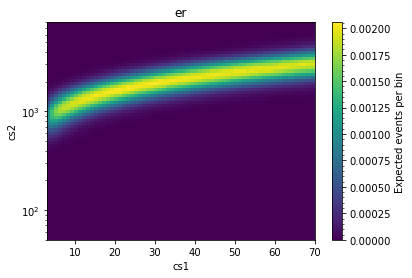

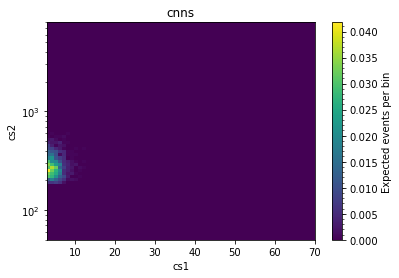

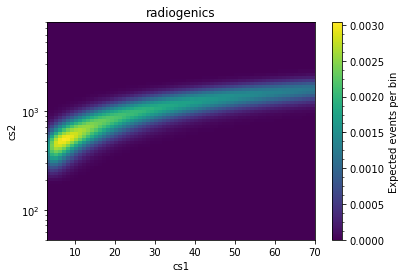

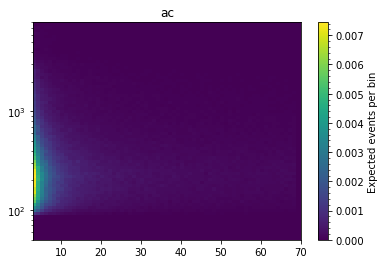

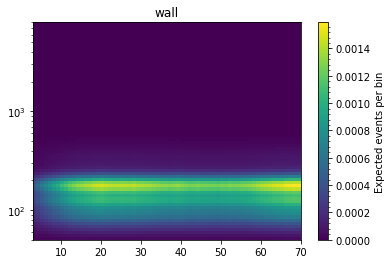

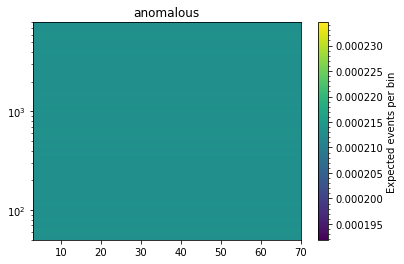

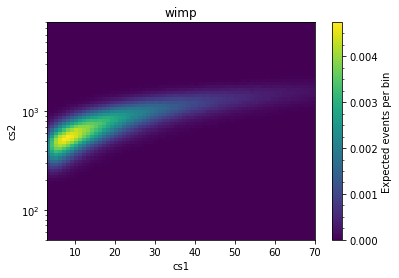

In [34]:
def plot_model(m):
    for s in m.sources:
        pdf = s._pdf_histogram
        events_per_bin = pdf * pdf.bin_volumes()
        events_per_bin.plot(cblabel='Expected events per bin')

        plt.title(s.name)
        plt.yscale('log')
        plt.show()
        
plot_model(m)

In the above events_per_bin is a multihist Histdd object. 
You can get the raw values out with .histogram. For more information, see the multihist tutorial [here](https://github.com/JelleAalbers/multihist/blob/master/Multihist%20example%20.ipynb).



# Simulating fake data

m.simulate() creates a fake dataset:

In [5]:
fake_d = m.simulate()
pd.DataFrame.from_records(fake_d).head()

,source,energy,r2,theta,z,p_photon_detected,p_electron_detected,electrons_produced,photons_produced,electrons_detected,electron_lifetime,s1_photons_detected,s1_photoelectrons_produced,s1,s2,cs1,cs2,csratio
0,0,3.716491,1348.909618,1.438951,-52.469607,0.125679,0.446582,143,133,64,452000.0,15,20,24.555420,716.0,24.499263,1603.290737,65.442406
1,0,6.149506,1094.936754,1.749624,-80.671519,0.158118,0.289551,213,231,67,452000.0,38,42,41.545641,823.0,32.946776,2842.327408,86.270274
2,0,8.639309,199.119339,2.358821,-17.518703,0.095982,0.764026,256,374,193,452000.0,34,34,35.603873,2209.0,46.512887,2891.264743,62.160510
3,0,3.931741,174.148628,0.308420,-51.700427,0.127075,0.451890,150,135,70,452000.0,16,17,16.174036,791.0,15.959682,1750.424785,109.677922
4,0,3.634358,1056.293013,1.815125,-80.906407,0.159257,0.288508,145,126,38,452000.0,23,25,22.269099,417.0,17.533578,1445.365206,82.434127


The 'source' column contains the index of the source (in m.sources) which generated the event. Laidbax includes a small shorthand for visulization:

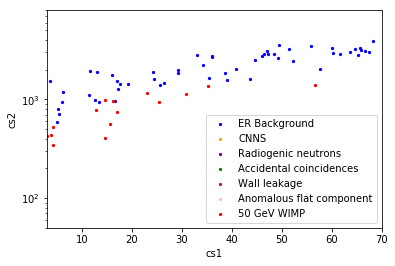

In [6]:
m.show(fake_d)
plt.yscale('log')
plt.legend(loc='lower right')

# Custom energy spectrum

Here's a rather unusual spectrum. If your theorists are coming up with this, ask what they are smoking.

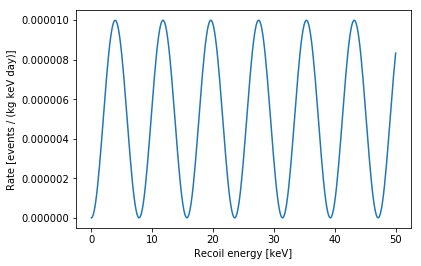

In [36]:
es = np.linspace(0, 50, 300)
dr = 1e-5 * np.sin(0.4 * es)**2
plt.plot(es, dr)
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events / (kg keV day)]")

Laidbax/blueice needs a dictionary with configuration options to know how to simulate this source:

In [51]:
source_config = {
    'energy_distribution': (es, dr),
    'name': 'magic',
    'label': 'Magic particles',
    'recoil_type': 'nr',
    'color': 'black',
    # The amount of events to simulate to create the PDF
    # Depending on how important deep tails are for your model, you may want
    # to increase this from the default of 1e6.
    'n_events_for_pdf': 1e6,
    # This tells blueice which settings are irrelevant for the source.
    # Since it's an NR source, this includes all the ER parameters.
    # It helps blueice's caching to know which settings cannot change the model.
    # However, if you just want the nominal models and/or don't care about a small
    # slowdown, this can be safely ignored.
    'extra_dont_hash_settings': base_model.nr_ignore_settings}

# Copy the old config
from copy import deepcopy
new_config = deepcopy(base_model.config)

# Simulate only the new weird particle
new_config['sources'] = [source_config]

# If you want to keep the background models, and just replace the WIMPs by your model, instead do:
# new_config['sources'][-1] = source_config

# This will take a moment the first time (or when you change the energy spectrum)
m2 = bi.Model(new_config)

You can do everything as before:

In [55]:
model_summary(m2)

,expected_events,name
0,6.195339,magic


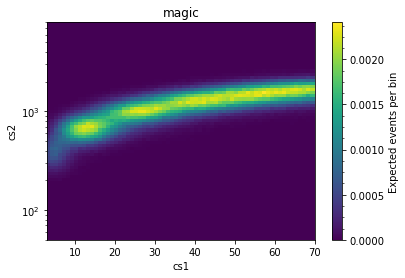

In [56]:
plot_model(m2)

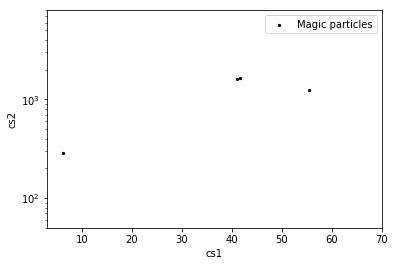

In [60]:
m2.show(m2.simulate())
plt.yscale('log')
plt.legend(loc='upper right')